In [1]:
# default_exp data

# Import

In [2]:
#export
from itertools import islice
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import skimage.segmentation
import torch
import torchvision
from IPython.core.debugger import set_trace
from PIL import Image, ImageFilter
from scipy.ndimage.filters import gaussian_filter
from torch.utils.data import Dataset, IterableDataset, DataLoader

from fiducial_detect.gen_cb import *

# Utility

In [3]:
#export
def normalize(X, r1, r2):
    return (X-r1[0])/(r1[1]-r1[0])*(r2[1]-r2[0])+r2[0]

In [4]:
#export
def trunc_norm(r, mu, sigma, sz=None):
    return scipy.stats.truncnorm.rvs((r[0]-mu)/sigma, 
                                     (r[1]-mu)/sigma,
                                     loc=mu,
                                     scale=sigma,
                                     size=sz)

# Transforms

In [5]:
#export
class Compose:
    def __init__(self, tfms):
        self.tfms = tfms
    
    def __call__(self, X, y):
        for tfm in self.tfms:
            X, y = tfm(X, y)
        return X, y

In [6]:
#export
class ToTensor:
    def __call__(self, X, y):
        return torchvision.transforms.ToTensor()(X), torch.from_numpy(y).long()

In [7]:
#export
class Normalize:
    def __init__(self, r1, r2):
        self.r1 = r1
        self.r2 = r2
        
    def __call__(self, X, y):
        return normalize(X, self.r1, self.r2), y

In [8]:
#export
class Resize:
    def __init__(self, sz):
        self.sz = sz
    
    def __call__(self, X, y):
        return (np.array(Image.fromarray(X).resize(self.sz, resample=Image.BILINEAR)),
                np.array(Image.fromarray(y).resize(self.sz, resample=Image.NEAREST)))

In [9]:
#export
class Blur:
    def __init__(self, sigma):
        self.sigma = sigma
    
    def __call__(self, X, y):
        return gaussian_filter(X, sigma=self.sigma), y

In [10]:
#export
class RandomBlur:
    def __init__(self, r, mu, sigma):
        self.r = r
        self.mu = mu
        self.sigma = sigma
    
    def __call__(self, X, y):
        return Blur(trunc_norm(self.r, self.mu, self.sigma))(X, y)

In [11]:
#export
class Contrast:
    def __init__(self, c):
        self.c = c
    
    def __call__(self, X, y):
        return X*self.c, y

In [12]:
#export
class RandomContrast:
    def __init__(self, r, mu, sigma):
        self.r = r
        self.mu = mu
        self.sigma = sigma
    
    def __call__(self, X, y):
        return Contrast(trunc_norm(self.r, self.mu, self.sigma))(X, y)

In [13]:
#export
class Brightness:
    def __init__(self, b):
        self.b = b
    
    def __call__(self, X, y):
        return X+self.b, y

In [14]:
#export
class RandomBrightness:
    def __init__(self, r, mu, sigma):
        self.r = r
        self.mu = mu
        self.sigma = sigma
    
    def __call__(self, X, y):
        return Brightness(trunc_norm(self.r, self.mu, self.sigma))(X, y)

In [15]:
#export
class Grad:
    def __init__(self, r, theta):
        self.r = r
        self.theta = theta
    
    def __call__(self, X, y):
        j, i = np.mgrid[0:X.shape[0], 0:X.shape[1]]
        grad = np.cos(self.theta)*i+np.sin(self.theta)*j
        grad = normalize(grad, (grad.min(), grad.max()), self.r)
        return X+grad.astype(np.float32), y

In [16]:
#export
class RandomGrad:
    def __init__(self, r):
        self.r = r
    
    def __call__(self, X, y):
        theta = np.random.uniform(0, 2*np.pi)
        return Grad(self.r, theta)(X, y)

In [17]:
#export
class Clip:
    def __init__(self, r):
        self.r = r
    
    def __call__(self, X, y):
        X[X < self.r[0]] = self.r[0]
        X[X > self.r[1]] = self.r[1]
        return X, y

In [18]:
#export
class Noise:
    def __init__(self, r, mu, sigma):
        self.r = r
        self.mu = mu
        self.sigma = sigma
    
    def __call__(self, X, y):
        X += trunc_norm(self.r, self.mu, self.sigma, X.shape).astype(np.float32)
        return X, y

# Dataloaders

In [19]:
#export
class IsliceDataloader(DataLoader):
    # NOTE: cannot monkey patch __iter__ so must inherit (according to stackoverflow)
    def __init__(self, num_batches, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_batches = num_batches
        
    def __iter__(self):
        return islice(super().__iter__(), self.num_batches)

# Datasets

In [20]:
#export
class SyntheticMaskDataSet(IterableDataset):
    def __init__(self, tfms=None):
        self.tfms = tfms
        
        # Set geometry options
        opts = {}
        opts['height_cb']           = 50.8
        opts['width_cb']            = 50.8
        opts['num_targets_height']  = 16
        opts['num_targets_width']   = 16
        opts['spacing_target']      = 2.032
        opts['height_fp']           = 42.672
        opts['width_fp']            = 42.672
        opts['size_fiducial']       = 2.5*opts['spacing_target']
        opts['size_target']         = opts['spacing_target']
        self.opts = opts

        # Set calibration board world coordinates
        self.coords_cb_w = poly2coords(get_poly_cb(get_fiducial_poly, 
                                                   get_checker_poly, 
                                                   opts))

        # Set camera matrix
        self.h, self.w = 1536, 2048
        x_o, y_o = (self.w-1)/2, (self.h-1)/2
        alpha = 3650
        self.A = [[alpha,     0,    x_o],
                  [    0, alpha,    y_o],
                  [    0,     0,      1]]

        # Set ranges for position of calibration board
        self.r_t_z = [150, 300]
        self.r_theta_t_x = [-np.pi/64, np.pi/64]
        self.r_theta_t_y = [-np.pi/32, np.pi/32]
        
        self.r_theta_x = [-np.pi/4, np.pi/4]
        self.r_theta_y = [-np.pi/4, np.pi/4]
        self.r_theta_z = [-np.pi, np.pi]
                
    def _get_H(self):
        # Sample position of calibration board
        t_z = np.random.uniform(self.r_t_z[0], self.r_t_z[1])
        theta_t_x = np.random.uniform(self.r_theta_t_x[0], self.r_theta_t_x[1])
        theta_t_y = np.random.uniform(self.r_theta_t_y[0], self.r_theta_t_y[1])

        theta_x = np.random.uniform(self.r_theta_x[0], self.r_theta_x[1])
        theta_y = np.random.uniform(self.r_theta_y[0], self.r_theta_y[1]) 
        theta_z = np.random.uniform(self.r_theta_z[0], self.r_theta_z[1]) 
        
        # Get homography
        t = euler2R([theta_t_x, theta_t_y, 0])@np.array([[0], [0], [t_z]])
        R = euler2R([theta_x, theta_y, theta_z])
        return ARt2H(self.A,R,t)
        
    def _get_img(self, H):
        img = np.zeros((self.h, self.w), dtype=np.float32)
        return draw_cb_coords(homography_coords(self.coords_cb_w, H), img)
        
    def _get_mask(self, H):
        s_f = self.opts['size_fiducial']
        mask = np.zeros((self.h, self.w), dtype=np.int32)
        ps_fp_w = get_ps_fp(self.opts)
        for idx, p_fp_w in enumerate(ps_fp_w):
            ps_f_p = homography_ps(np.array(get_circle_poly(p_fp_w, s_f/2).exterior.coords), H)
            draw_ps(ps_f_p, mask, idx+1)
        return mask  
        
    def __next__(self):
        H = self._get_H()        # Sample homography
        img = self._get_img(H)   # Get image
        mask = self._get_mask(H) # Get corresponding mask
            
        if self.tfms is not None:
            img, mask = self.tfms(img, mask)
            
        return img, mask
            
    def __iter__(self):
        return self

In [21]:
#export
class RealMaskDataSet(Dataset):
    def __init__(self, dir_data, tfms=None):
        self.dir_data = dir_data
        self.tfms = tfms
        
        self.files_mask = [p for p in dir_data.glob('*.png') if p.as_posix().endswith('_mask.png')]
        self.files_img = [p.parent/(p.stem[:-5] + p.suffix) for p in self.files_mask]
        
    def __len__(self):
        return len(self.files_img)
    
    def __getitem__(self, idx):
        img = np.array(Image.open(self.files_img[idx]), dtype=np.float32)/2**16 # Images are uint16
        mask = np.array(Image.open(self.files_mask[idx]), dtype=np.int32)
                       
        if self.tfms is not None:
            img, mask = self.tfms(img, mask)
            
        return img, mask

### Test

In [22]:
def plot_ds(ds, num_it=20):
    cs = ['r', 'g', 'b', 'y']
    for idx, (X, y) in enumerate(islice(ds, num_it)):
        plt.figure(idx, figsize=(10,10))
        plt.imshow(X[0], vmin=-1, vmax=1, cmap='gray', interpolation='bilinear')
        for idx, c in enumerate(cs):
            y_boundary, x_boundary = np.where(skimage.segmentation.find_boundaries(y == (idx+1)))
            plt.scatter(x_boundary, y_boundary, s=1, c=c)

In [23]:
tfms = Compose([Resize((512, 384)), 
                Normalize((0, 1), (-1, 1)),
                RandomContrast((0.5, 1.5), 1, 0.5),
                RandomBrightness((-1.0, 0.5), -0.25, 0.5),
                RandomBlur((0, 1.5), 0.75, 0.5),
                Noise((-0.1, 0.1), 0, 0.1),
                RandomGrad((-0.5, 0.5)),
                Clip((-1,1)),
                ToTensor()])

ds_mask_synth = SyntheticMaskDataSet(tfms=tfms)

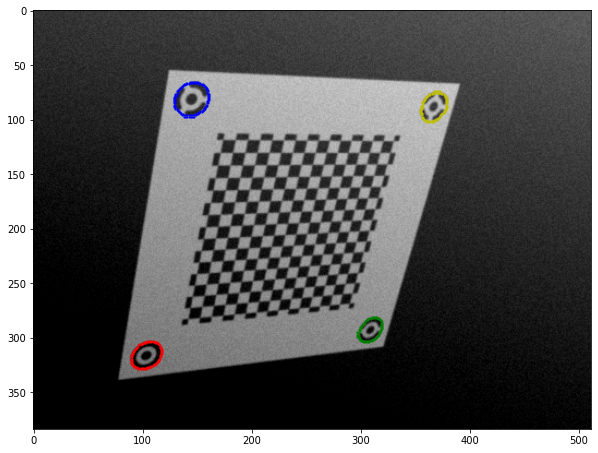

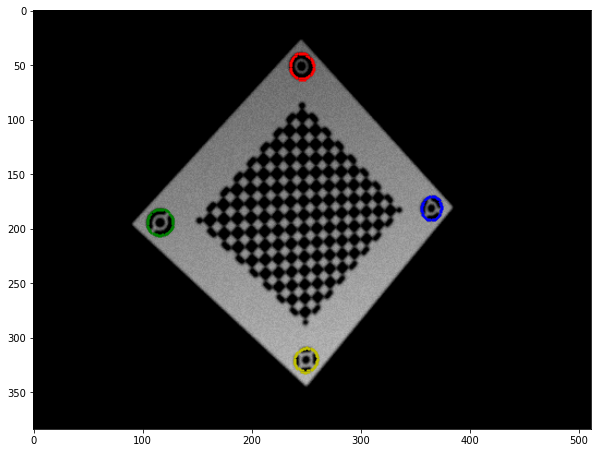

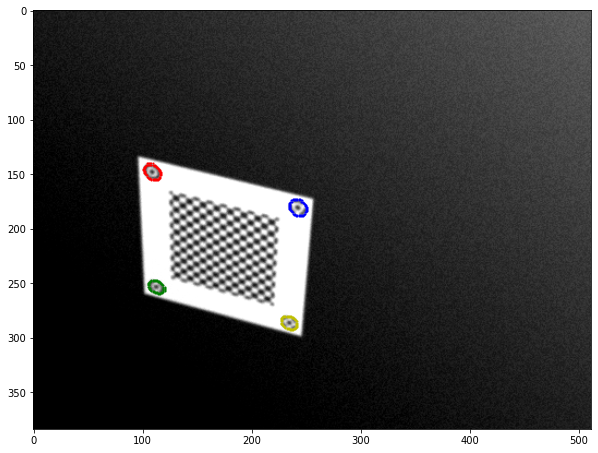

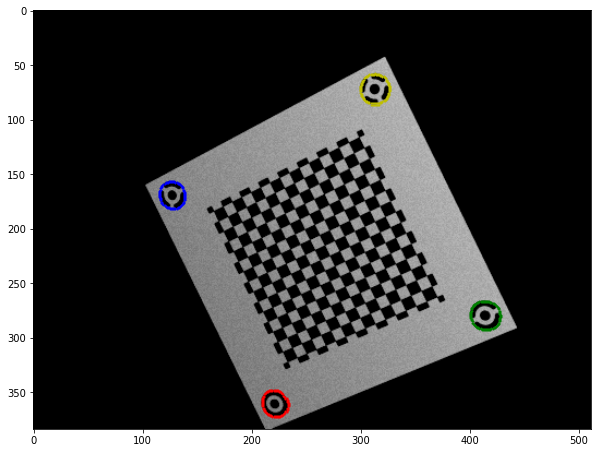

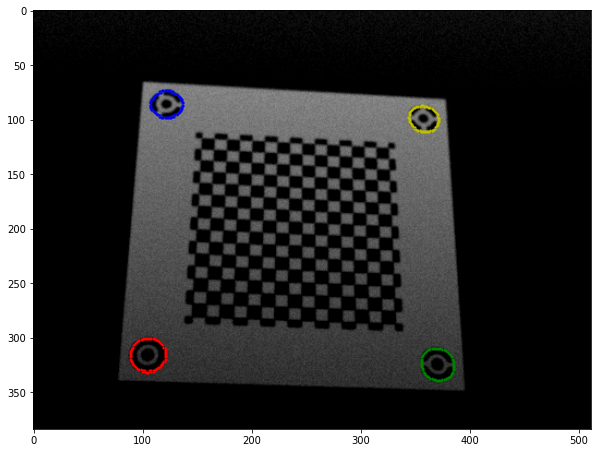

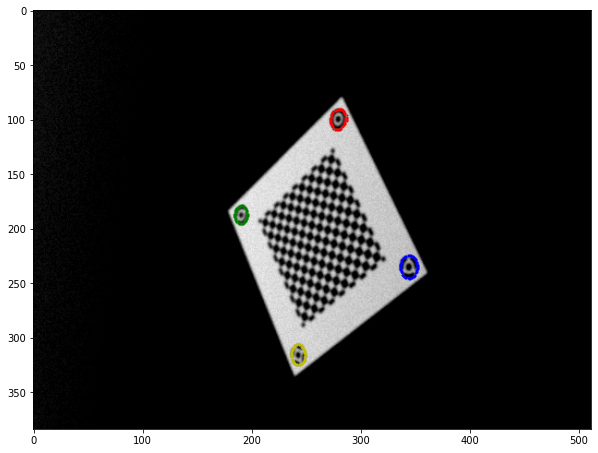

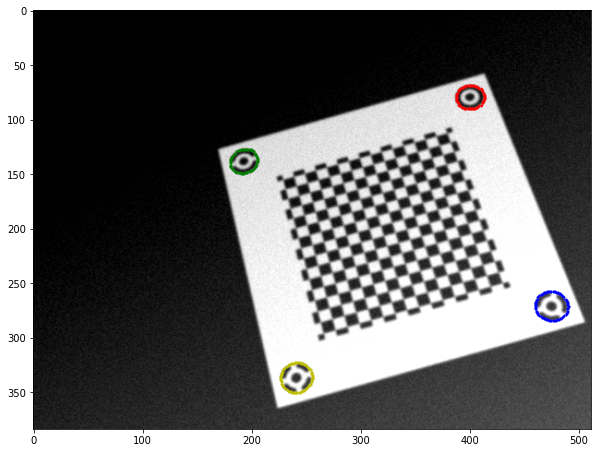

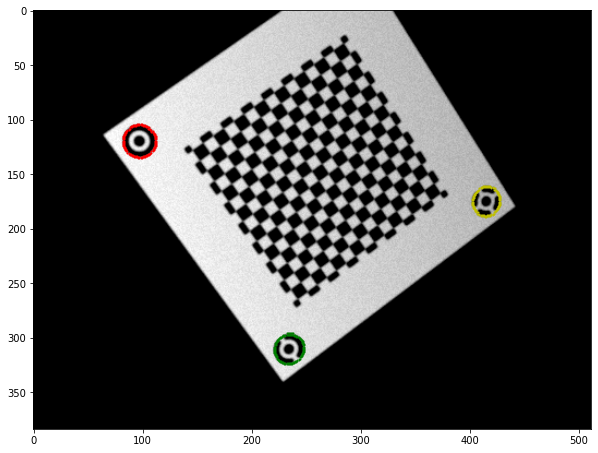

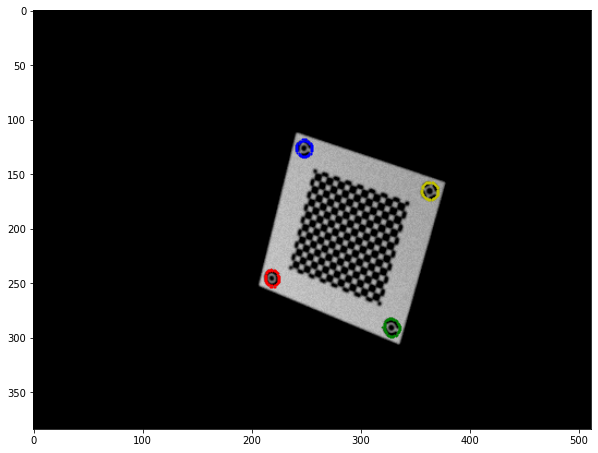

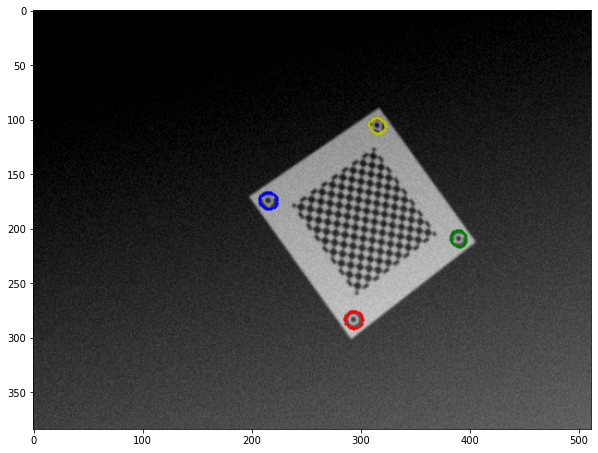

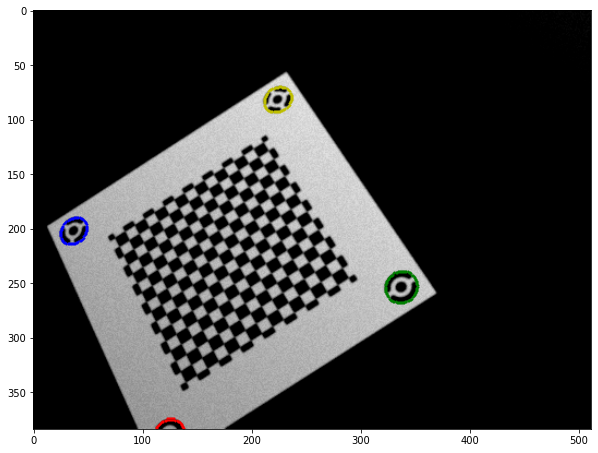

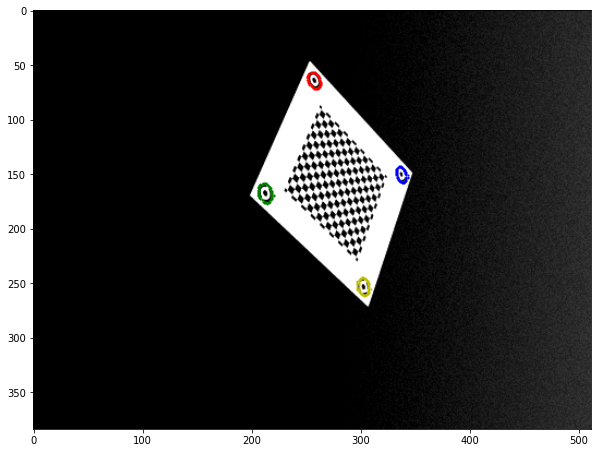

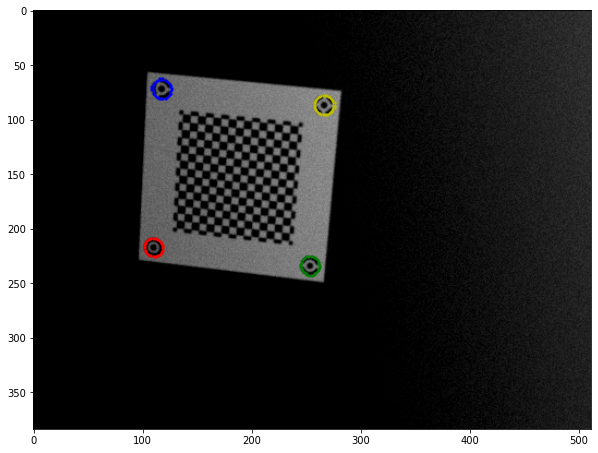

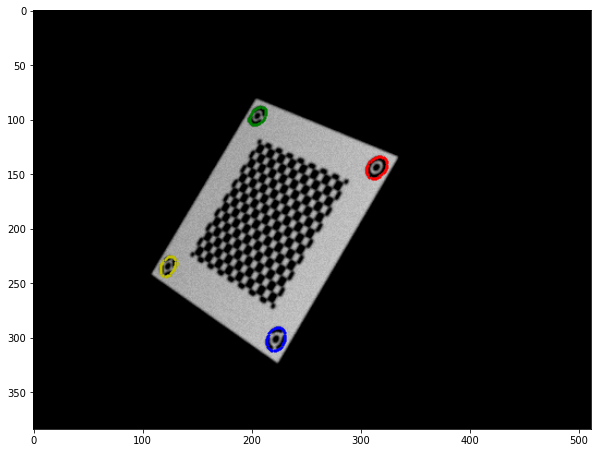

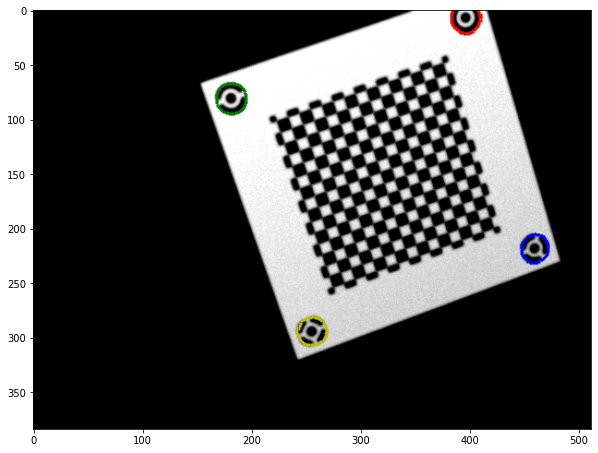

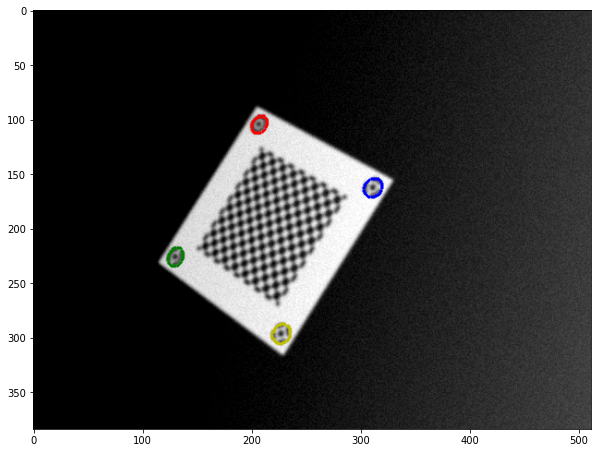

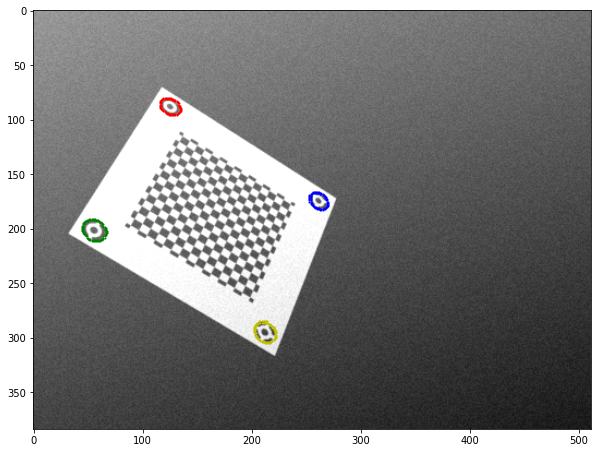

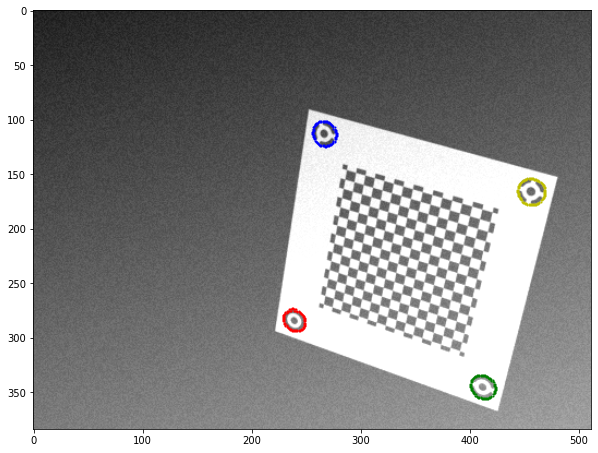

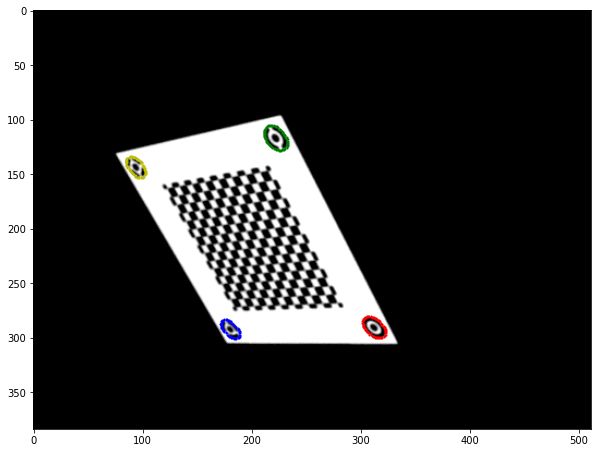

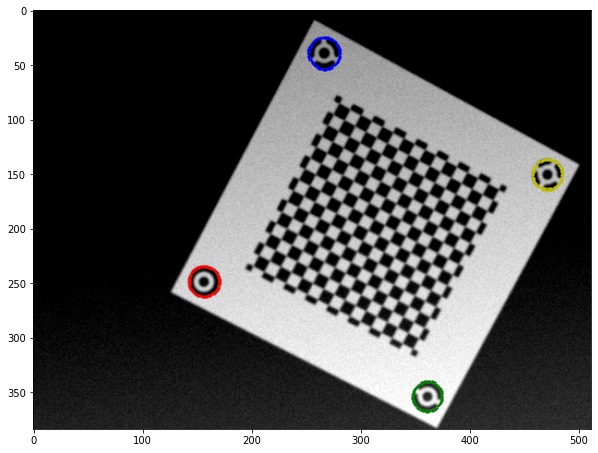

In [24]:
plot_ds(ds_mask_synth)

In [25]:
tfms = Compose([Resize((512, 384)), 
                Normalize((0, 1), (-1, 1)),
                ToTensor()])

ds_mask_real = RealMaskDataSet(Path('data'), tfms=tfms)

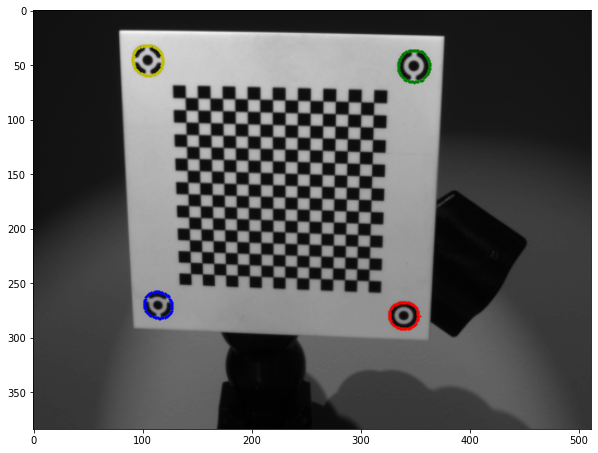

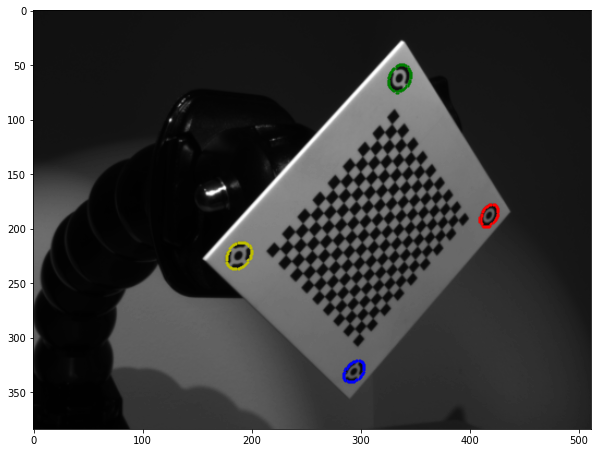

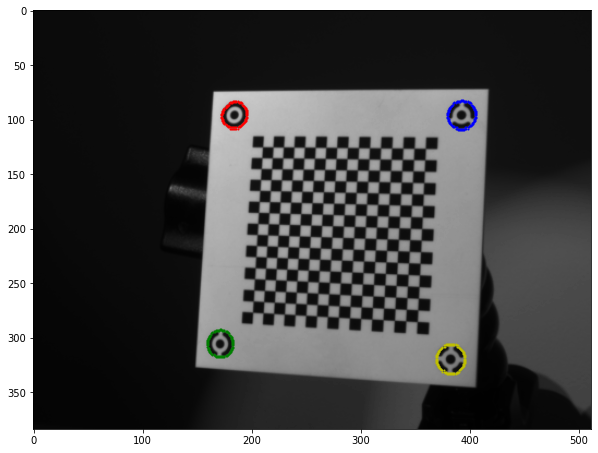

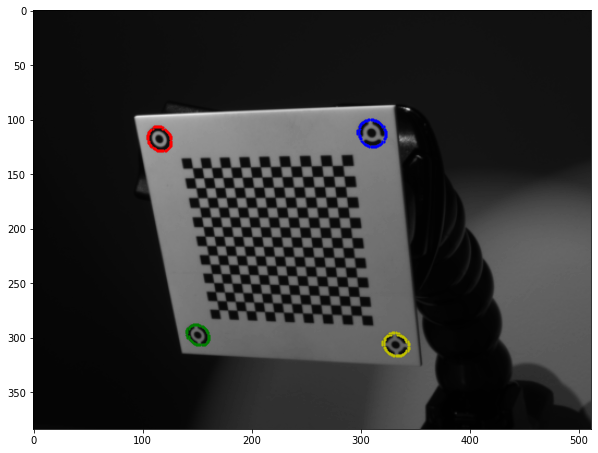

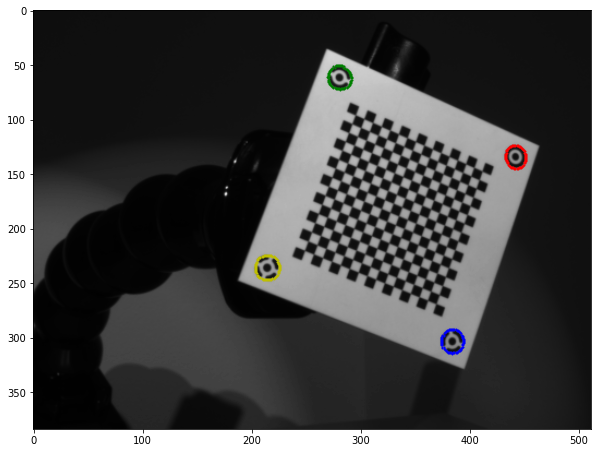

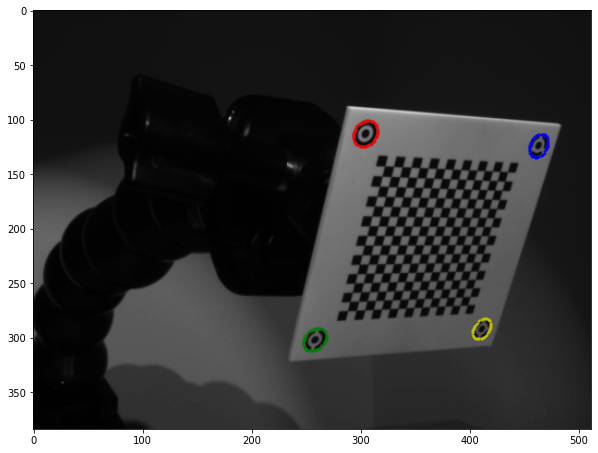

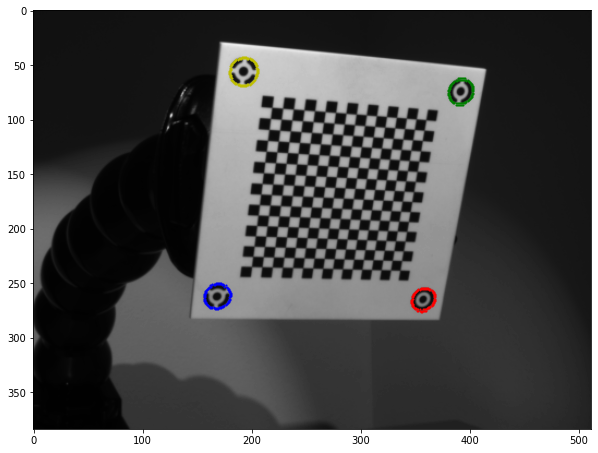

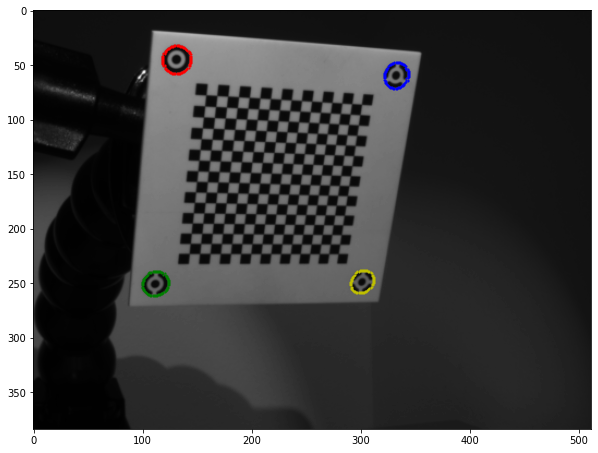

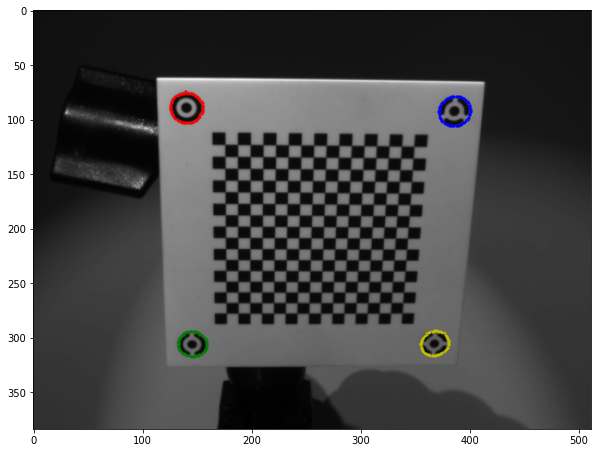

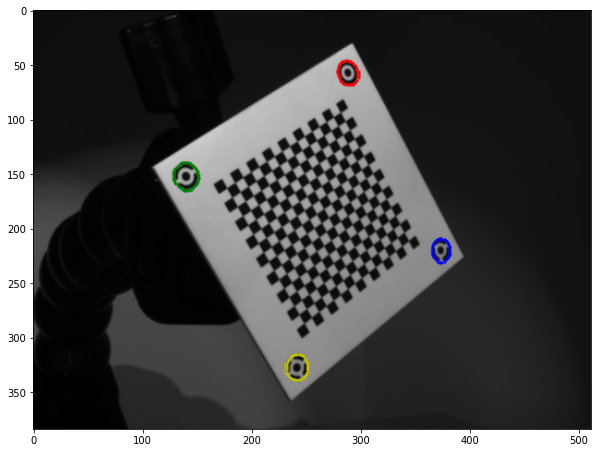

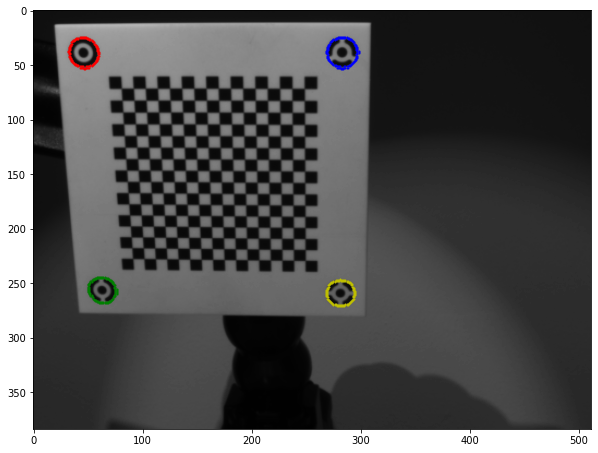

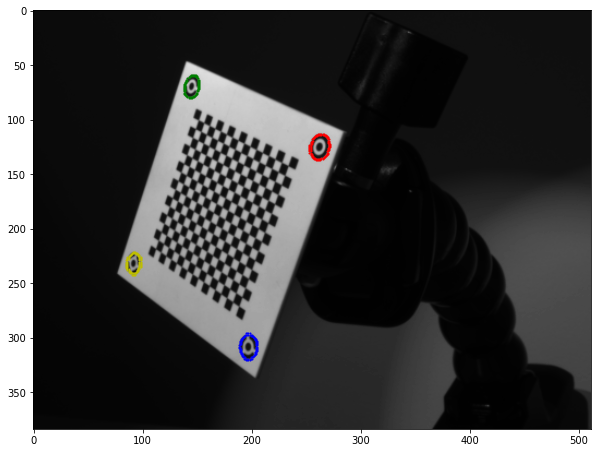

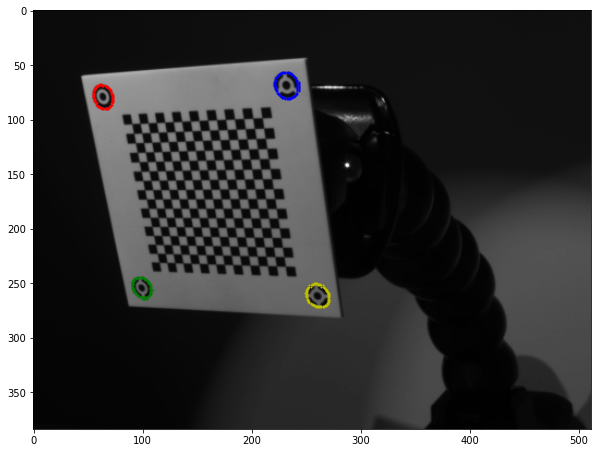

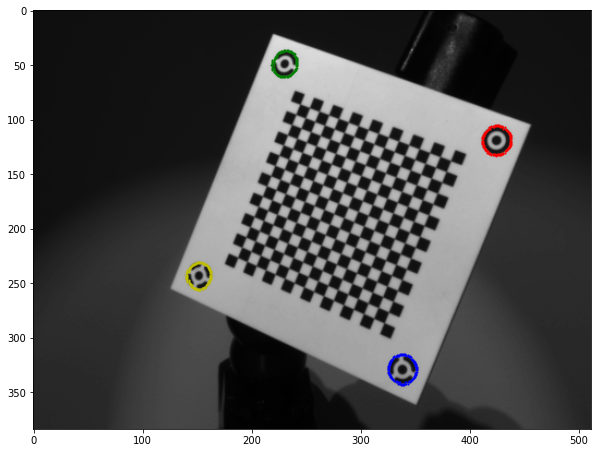

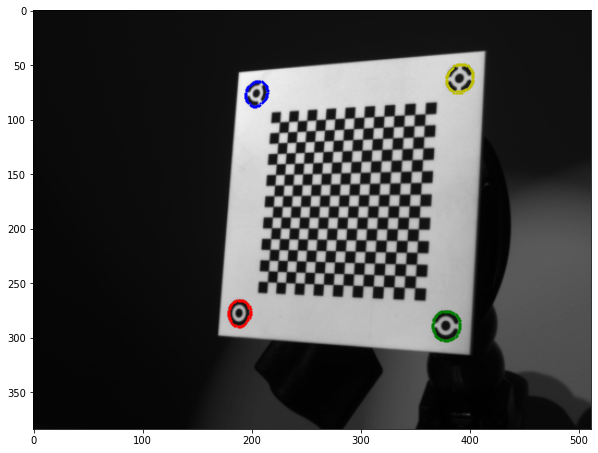

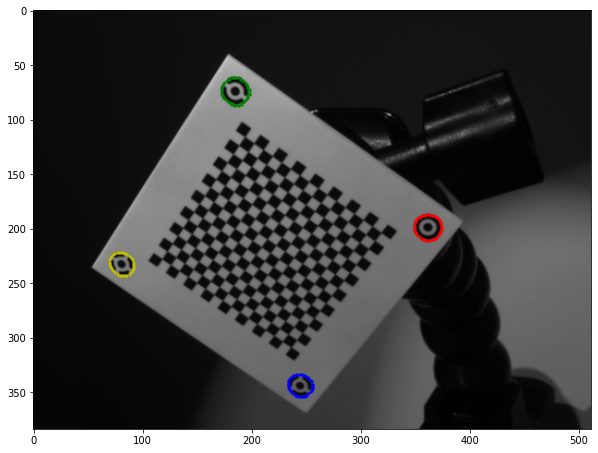

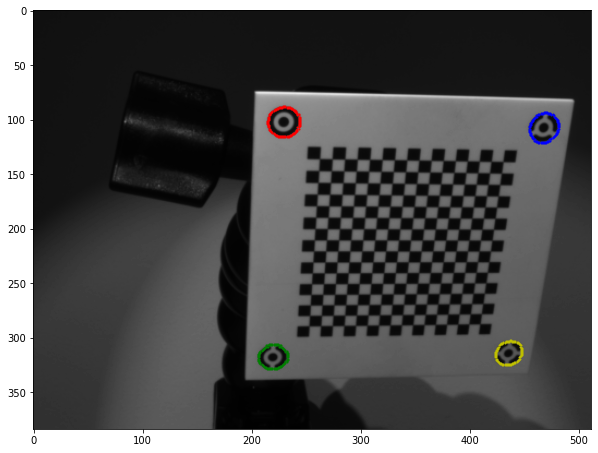

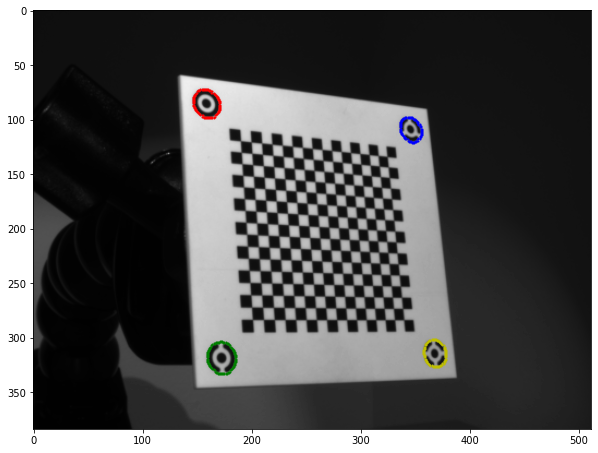

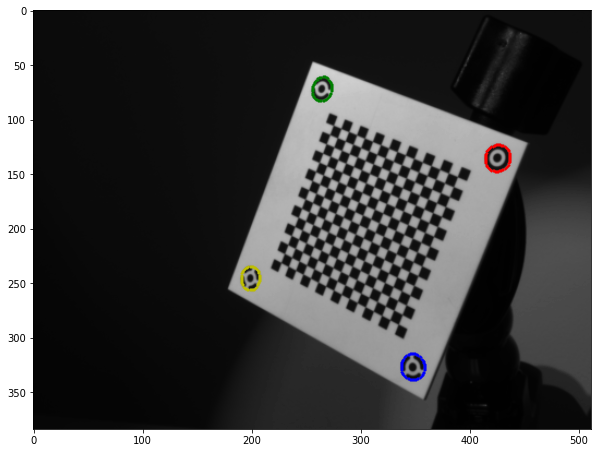

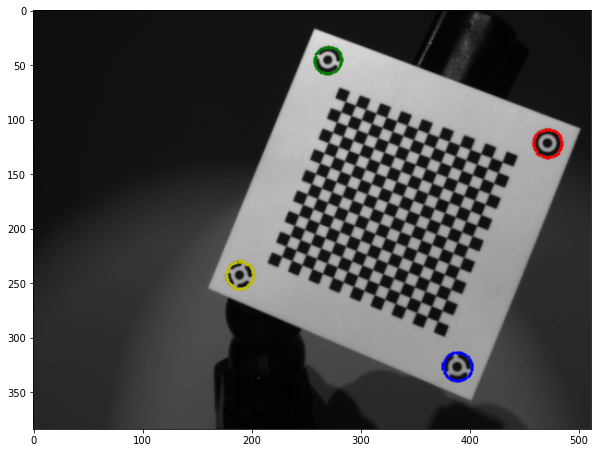

In [26]:
plot_ds(ds_mask_real)

# Build

In [27]:
!nbdev_build_lib

Converted data.ipynb.
Converted gen_cb.ipynb.
Converted models.ipynb.
Converted train.ipynb.
